# Predicting Women's Freedom Globally

In [1]:
# Make code toggle-able for easier review.
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<i>The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a></i>.''')

In [2]:
###### Math, Plotting, and Data Frames
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import math
###### Preprocessing and Hyperparameter tuning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
###### Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
# import xgboost as xgb
###### Metrics and Scoring
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('hfi_cc_2018.csv')

print(df.columns)
print(df.shape)
df.describe()

Index(['year', 'ISO_code', 'countries', 'region', 'pf_rol_procedural',
       'pf_rol_civil', 'pf_rol_criminal', 'pf_rol', 'pf_ss_homicide',
       'pf_ss_disappearances_disap',
       ...
       'ef_regulation_business_bribes', 'ef_regulation_business_licensing',
       'ef_regulation_business_compliance', 'ef_regulation_business',
       'ef_regulation', 'ef_score', 'ef_rank', 'hf_score', 'hf_rank',
       'hf_quartile'],
      dtype='object', length=123)
(1458, 123)


,year,pf_rol_procedural,pf_rol_civil,pf_rol_criminal,pf_rol,pf_ss_homicide,pf_ss_disappearances_disap,pf_ss_disappearances_violent,pf_ss_disappearances_organized,pf_ss_disappearances_fatalities,...,ef_regulation_business_bribes,ef_regulation_business_licensing,ef_regulation_business_compliance,ef_regulation_business,ef_regulation,ef_score,ef_rank,hf_score,hf_rank,hf_quartile
count,1458.000000,880.000000,880.000000,880.000000,1378.000000,1378.000000,1369.000000,1378.000000,1279.000000,1378.000000,...,1283.000000,1357.000000,1368.000000,1374.000000,1378.000000,1378.000000,1378.000000,1378.000000,1378.000000,1378.000000
mean,2012.000000,5.589355,5.474770,5.044070,5.309641,7.412980,8.341855,9.519458,6.772869,9.584972,...,4.886192,7.698494,6.981858,6.317668,7.019782,6.785610,76.973149,6.993444,77.007983,2.490566
std,2.582875,2.080957,1.428494,1.724886,1.529310,2.832947,3.225902,1.744673,2.768983,1.559826,...,1.889168,1.728507,1.979200,1.230988,1.027625,0.883601,44.540142,1.025811,44.506549,1.119698
min,2008.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.009841,2.483540,2.880000,1.000000,3.765827,1.000000,1.000000
25%,2010.000000,4.133333,4.549550,3.789724,4.131746,6.386978,10.000000,10.000000,5.000000,9.942607,...,3.433786,6.874687,6.368178,5.591851,6.429498,6.250000,38.000000,6.336685,39.000000,1.000000
50%,2012.000000,5.300000,5.300000,4.575189,4.910797,8.638278,10.000000,10.000000,7.500000,10.000000,...,4.418371,8.074161,7.466692,6.265234,7.082075,6.900000,77.000000,6.923840,76.000000,2.000000
75%,2014.000000,7.389499,6.410975,6.400000,6.513178,9.454402,10.000000,10.000000,10.000000,10.000000,...,6.227978,8.991882,8.209310,7.139718,7.720955,7.410000,115.000000,7.894660,115.000000,3.000000
max,2016.000000,9.700000,8.773533,8.719848,8.723094,9.926568,10.000000,10.000000,10.000000,10.000000,...,9.623811,9.999638,9.865488,9.272600,9.439828,9.190000,162.000000,9.126313,162.000000,4.000000


**There are 123 features in this dataset. To minimize this, the documentation for the Human Freedom Index shows that most categories are actually sub-categories. So I'll use the main categories, which greatly reduces the features to look through as well as significantly reducing null values. It's safe to say most countries were able to answer broad questions, but not all countries were able to answer more specific questions (sub-category) for some years, or even all reported years.**

In [4]:
hfi_df = pd.DataFrame() # creating a empty dataset

hfi_df["year"] = df.year                             # Year of Observation
hfi_df["country"] = df.countries                     # Name of the Country
hfi_df["region"] = df.region                         # Year of Observation

hfi_df["rule_of_law"] = df.pf_rol                    # Rule Of Law
hfi_df["homicide"] = df.pf_ss_homicide               # Homicide
hfi_df["disappearances"] = df.pf_ss_disappearances   # Disappearances, conflict, and terrorism
hfi_df["security_safety"] = df.pf_ss                 # Security and Safety
hfi_df["movement"] = df.pf_movement                  # Movement
hfi_df["religion"] = df.pf_religion                  # Religion
hfi_df["association"] = df.pf_association            # Association, Assembly, and Civil Society
hfi_df["expression"] = df.pf_expression              # Expression and Information
hfi_df["identity"] = df.pf_identity                  # Identity and Relationships
hfi_df["government"] = df.ef_government              # Size of Government
hfi_df["legal"] = df.ef_legal                        # Legal System and Property Rights
hfi_df["money_access"] = df.ef_money                 # Access to Sound Money
hfi_df["trade"] = df.ef_trade                        # Freedom to Trade Internationally
hfi_df["regulation"] = df.ef_regulation              # Regulation of Credit, Labor, and Business

hfi_df['pers_free_score'] = df.pf_score              #Personal Freedom (score)
hfi_df['pers_free_rank'] = df.pf_rank                #Personal Freedom (rank)
hfi_df["eco_free_score"] = df.ef_score               # Economical Freedom Score
hfi_df["eco_free_rank"] = df.ef_rank                 # Economical Freedom Rank
hfi_df["free_score"] = df.hf_score                   # Human Freedom Score
hfi_df["free_rank"] = df.hf_rank                     # Human Freedom Rank

hfi_df['women'] = df.pf_ss_women                     # Women's Freedom and Safety

In [5]:
hfi_df.head()

,year,country,region,rule_of_law,homicide,disappearances,security_safety,movement,religion,association,...,money_access,trade,regulation,pers_free_score,pers_free_rank,eco_free_score,eco_free_rank,free_score,free_rank,women
0,2016,Albania,Eastern Europe,5.291752,8.920429,10.000000,8.806810,6.666667,9.192593,10.0,...,9.553657,8.214900,6.906901,7.596281,57.0,7.54,34.0,7.568140,48.0,7.500000
1,2016,Algeria,Middle East & North Africa,3.819566,9.456254,8.842060,8.043882,5.000000,4.944815,5.0,...,7.253894,4.127025,5.268992,5.281772,147.0,4.99,159.0,5.135886,155.0,5.833333
2,2016,Angola,Sub-Saharan Africa,3.451814,8.060260,8.500000,8.297865,5.000000,8.786667,4.0,...,5.606605,5.264754,5.518500,6.111324,117.0,5.17,155.0,5.640662,142.0,8.333333
3,2016,Argentina,Latin America & the Caribbean,5.744791,7.622974,9.498175,9.040383,10.000000,7.795926,7.5,...,5.614336,3.982547,5.369019,8.099696,42.0,4.84,160.0,6.469848,107.0,10.000000
4,2016,Armenia,Caucasus & Central Asia,5.003205,8.808750,9.349563,8.830549,6.666667,6.222222,6.5,...,9.521940,8.143241,7.378069,6.912804,84.0,7.57,29.0,7.241402,57.0,8.333333


In [6]:
hfi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 24 columns):
year               1458 non-null int64
country            1458 non-null object
region             1458 non-null object
rule_of_law        1378 non-null float64
homicide           1378 non-null float64
disappearances     1378 non-null float64
security_safety    1378 non-null float64
movement           1378 non-null float64
religion           1368 non-null float64
association        1129 non-null float64
expression         1378 non-null float64
identity           1378 non-null float64
government         1378 non-null float64
legal              1378 non-null float64
money_access       1376 non-null float64
trade              1377 non-null float64
regulation         1378 non-null float64
pers_free_score    1378 non-null float64
pers_free_rank     1378 non-null float64
eco_free_score     1378 non-null float64
eco_free_rank      1378 non-null float64
free_score         1378 non-null flo

In [7]:
hfi_df = hfi_df.dropna()

In [8]:
hfi_df.describe()

,year,rule_of_law,homicide,disappearances,security_safety,movement,religion,association,expression,identity,...,money_access,trade,regulation,pers_free_score,pers_free_rank,eco_free_score,eco_free_rank,free_score,free_rank,women
count,1127.000000,1127.000000,1127.000000,1127.000000,1127.000000,1127.000000,1127.000000,1127.00000,1127.000000,1127.000000,...,1127.000000,1127.000000,1127.000000,1127.000000,1127.000000,1127.000000,1127.000000,1127.000000,1127.000000,1127.000000
mean,2012.174800,5.420930,7.701888,8.806852,8.299044,7.788376,7.807345,7.43042,7.932274,7.401287,...,8.207370,7.113832,7.009030,7.265964,75.683230,6.829805,74.133984,7.047884,75.097604,8.388391
std,2.556044,1.572611,2.621717,1.577774,1.335574,2.605226,1.359640,2.48487,1.462292,3.213975,...,1.426473,1.132764,1.034022,1.392312,46.073248,0.916088,46.126850,1.053444,46.104612,1.824118
min,2008.000000,1.816300,0.000000,0.000000,3.963850,0.000000,0.000000,0.25000,1.944578,0.000000,...,0.947500,1.781689,2.483540,3.116028,1.000000,2.880000,1.000000,4.095028,1.000000,0.000000
25%,2010.000000,4.199585,6.621612,8.364350,7.447186,6.666667,7.120833,6.00000,6.993336,5.000000,...,7.027052,6.453611,6.398812,6.149575,33.000000,6.240000,33.000000,6.308117,33.000000,7.066667
50%,2012.000000,5.098413,8.884720,9.491571,8.427232,8.333333,8.103704,8.00000,8.238095,9.250000,...,8.637098,7.259593,7.075597,7.194329,76.000000,7.000000,71.000000,6.935416,75.000000,9.166667
75%,2014.000000,6.696551,9.534589,9.997627,9.587539,10.000000,8.792593,9.50000,9.250000,10.000000,...,9.440118,7.979492,7.724851,8.668821,117.000000,7.480000,116.000000,8.047260,116.000000,10.000000
max,2016.000000,8.723094,9.918035,10.000000,9.959940,10.000000,9.945926,10.00000,9.797619,10.000000,...,9.922187,9.561530,9.439828,9.568154,160.000000,9.190000,162.000000,9.126313,161.000000,10.000000


In [9]:
hfi_df.isnull().sum()

year               0
country            0
region             0
rule_of_law        0
homicide           0
disappearances     0
security_safety    0
movement           0
religion           0
association        0
expression         0
identity           0
government         0
legal              0
money_access       0
trade              0
regulation         0
pers_free_score    0
pers_free_rank     0
eco_free_score     0
eco_free_rank      0
free_score         0
free_rank          0
women              0
dtype: int64

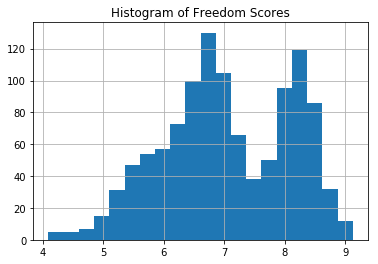

In [10]:
hfi_df.free_score.hist(bins=20)
plt.title('Histogram of Freedom Scores')
plt.show()

**Most coutries feel somewhat free (175 at just below 7). There is also a good chunk of countries that feel very free with 125 at just above 8.**

In [11]:
freest_30 = hfi_df.groupby('country')['free_score'].mean().sort_values(ascending=False)[:30]
freest_30

country
Hong Kong         8.970342
New Zealand       8.857553
Switzerland       8.782947
Canada            8.619081
Australia         8.613201
Finland           8.606345
Denmark           8.589246
Norway            8.527672
United Kingdom    8.513016
Luxembourg        8.494836
Ireland           8.477890
Sweden            8.445823
Austria           8.424141
Netherlands       8.423338
Germany           8.419142
Estonia           8.390369
Malta             8.324871
United States     8.304748
Belgium           8.227984
Czech Rep.        8.209978
Lithuania         8.180404
Japan             8.179346
Portugal          8.165574
Iceland           8.151914
Cyprus            8.148435
Chile             8.144992
Spain             8.141659
Taiwan            8.135682
Mauritius         8.130396
Latvia            8.124512
Name: free_score, dtype: float64

The top 30 countries are very similar in score

In [80]:
# Top 30 countries for women
hfi_df.groupby('country')['women'].mean().sort_values(ascending=False)[:30]

country
Netherlands       1.0
Portugal          1.0
Korea, South      1.0
Costa Rica        1.0
Latvia            1.0
Colombia          1.0
Lithuania         1.0
Luxembourg        1.0
Malta             1.0
Canada            1.0
Mongolia          1.0
Cambodia          1.0
Finland           1.0
New Zealand       1.0
Bulgaria          1.0
Norway            1.0
Panama            1.0
Kazakhstan        1.0
Croatia           1.0
Japan             1.0
Iceland           1.0
Estonia           1.0
Germany           1.0
El Salvador       1.0
Guatemala         1.0
Ecuador           1.0
Hungary           1.0
Dominican Rep.    1.0
Jamaica           1.0
Denmark           1.0
Name: women, dtype: float64

Text(0.5,1,'Average Yearly Women Freedom by Region')

<Figure size 432x288 with 0 Axes>

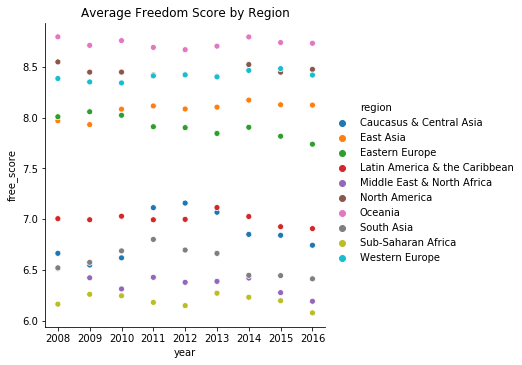

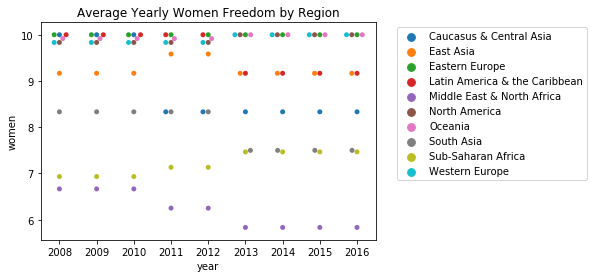

In [12]:
region_yr = hfi_df.groupby(['region', 'year']).median().reset_index()

# Plot human freedom by region
plt.figure()
sns.relplot(x='year', y='free_score', hue='region', data=region_yr)
plt.title('Average Freedom Score by Region')

#Plot women's freeodm by region
plt.figure()
sns.swarmplot(x="year", y="women", hue="region", data=region_yr)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
# sns.relplot(x='year', y='women', hue='region', sizes=(0,10), data=region_yr)
plt.title('Average Yearly Women Freedom by Region')

In [13]:
compCols = ['pers_free_score','money_access','association','security_safety','free_score','legal',
               'identity', 'religion']
def plot_compare(dataset,regions,compareCols):
    n = len(compareCols)
    f, axes = plt.subplots(math.ceil(n/2), 2, figsize=(16, 6*math.ceil(n/2)))
    axes = axes.flatten()
    #compareCols = ['Happiness Score','Economy','Family','Health (Life Expectancy)','Freedom','Trust (Government Corruption)']
    for i in range(len(compareCols)):
        col = compareCols[i]
        axi = axes[i]
        for region in regions:
            this_region = dataset[dataset['region']==region]
            sns.distplot(this_region[col], label=region, ax=axi)
            #sns.palplot(sns.color_palette(n_colors=10)) #change hist and kde line colors
        axi.legend()

Text(0.5,1,'A Closer look')

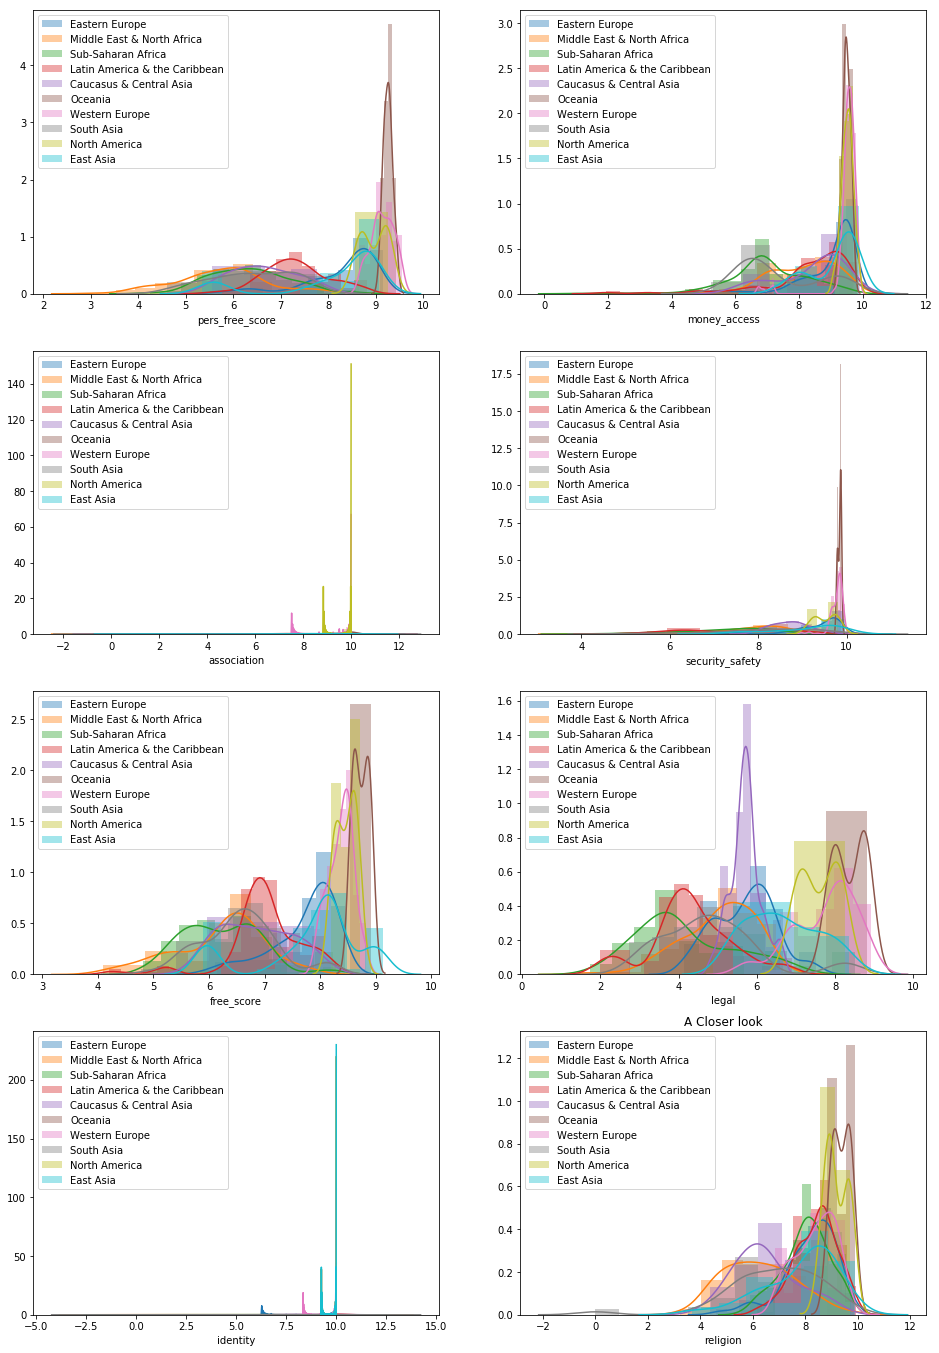

In [14]:
# All 10 Regions
regs = ['Eastern Europe', 'Middle East & North Africa',
       'Sub-Saharan Africa', 'Latin America & the Caribbean',
       'Caucasus & Central Asia', 'Oceania', 'Western Europe',
       'South Asia', 'North America', 'East Asia']
# regs = ['North America', 'Latin America & the Caribbean', 'Caucasus & Central Asia',
#        'Sub-Saharan Africa', 'South Asia', 'Middle East & North Africa']
plot_compare(hfi_df,regs,compCols)
plt.title('A Closer look')

Text(0.5,1,"Overall Freedom vs Women's Freedom")

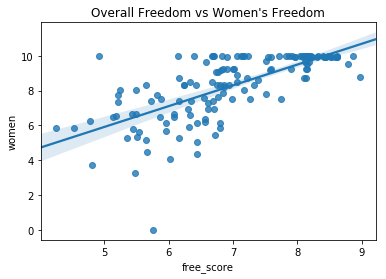

In [15]:
freest_avg = hfi_df.groupby('country')['free_score'].mean()
women_avg = hfi_df.groupby('country')['women'].mean()
# Plot avg human freedom vs avg women freedom
plt.figure()
sns.regplot(x=freest_avg, y=women_avg, data=region_yr)
plt.title('Overall Freedom vs Women\'s Freedom')

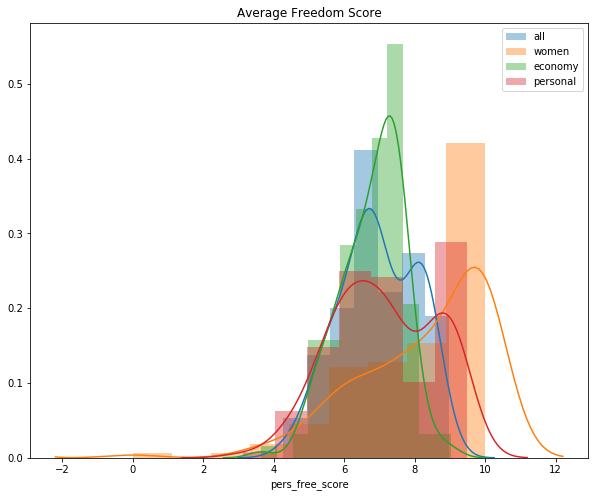

In [78]:
econ_avg = hfi_df.groupby('country')['eco_free_score'].mean()
pers_avg = hfi_df.groupby('country')['pers_free_score'].mean()
# All Freedom Hist
plt.figure()
sns.distplot(freest_avg, label="all")
sns.distplot(women_avg, label="women")
sns.distplot(econ_avg, label="economy")
sns.distplot(pers_avg, label="personal")
plt.title('Average Freedom Score')
plt.legend();

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text yticklabel objects>)

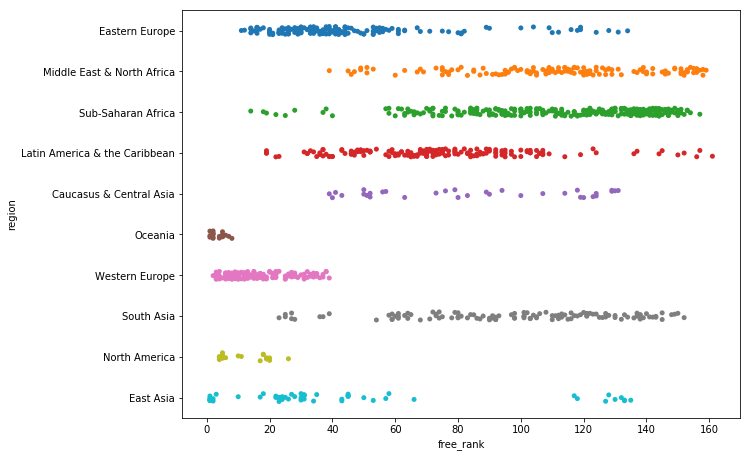

In [17]:
plt.figure(figsize = (10, 7.5))
g = sns.stripplot(x="free_rank", y="region", data=hfi_df, jitter=True)
plt.yticks(rotation=0)

In [18]:
hfi_df['women'].mean()

8.38839100852884

In [19]:
# make women's score into a binary column
# if 1 rating is good, if 0 rating is bad
hfi_df['women'] = np.where(hfi_df['women'] >= 8.39, 1, 0)
hfi_df.women.value_counts()

1    567
0    560
Name: women, dtype: int64

Text(0.5,1,'0: Opressed Women || 1: Free Women')

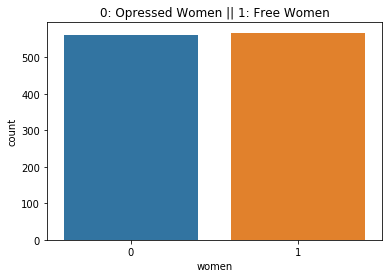

In [20]:
sns.countplot('women', data=hfi_df)
plt.title('0: Opressed Women || 1: Free Women')

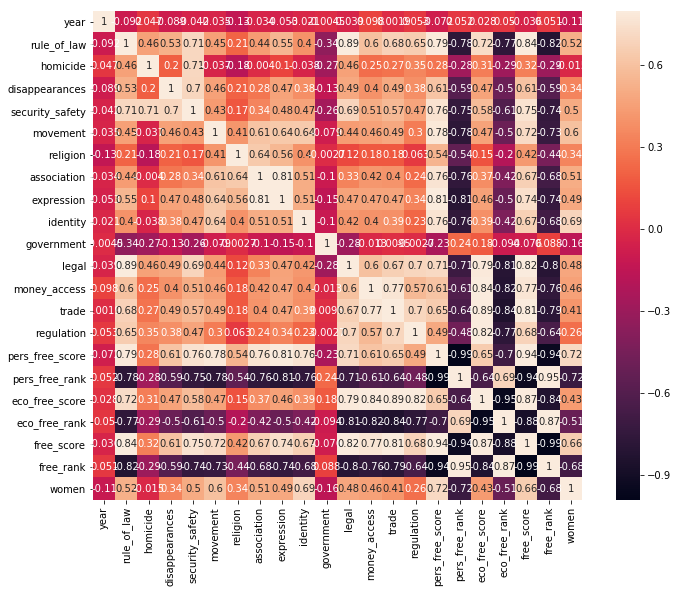

In [21]:
corrmat = hfi_df.corr()

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, annot=True, vmax=.8, square=True)
plt.show()

In [22]:
hfi_df.corr()['women'].abs().sort_values(ascending=False)

women              1.000000
pers_free_rank     0.715769
pers_free_score    0.715437
identity           0.693493
free_rank          0.680314
free_score         0.659537
movement           0.601298
rule_of_law        0.522270
eco_free_rank      0.510922
association        0.506905
security_safety    0.501125
expression         0.488710
legal              0.480496
money_access       0.460241
eco_free_score     0.429497
trade              0.411200
disappearances     0.343517
religion           0.341972
regulation         0.255533
government         0.158636
year               0.114688
homicide           0.015391
Name: women, dtype: float64

Text(0.5,1,'Closer Look at Correlated Features')

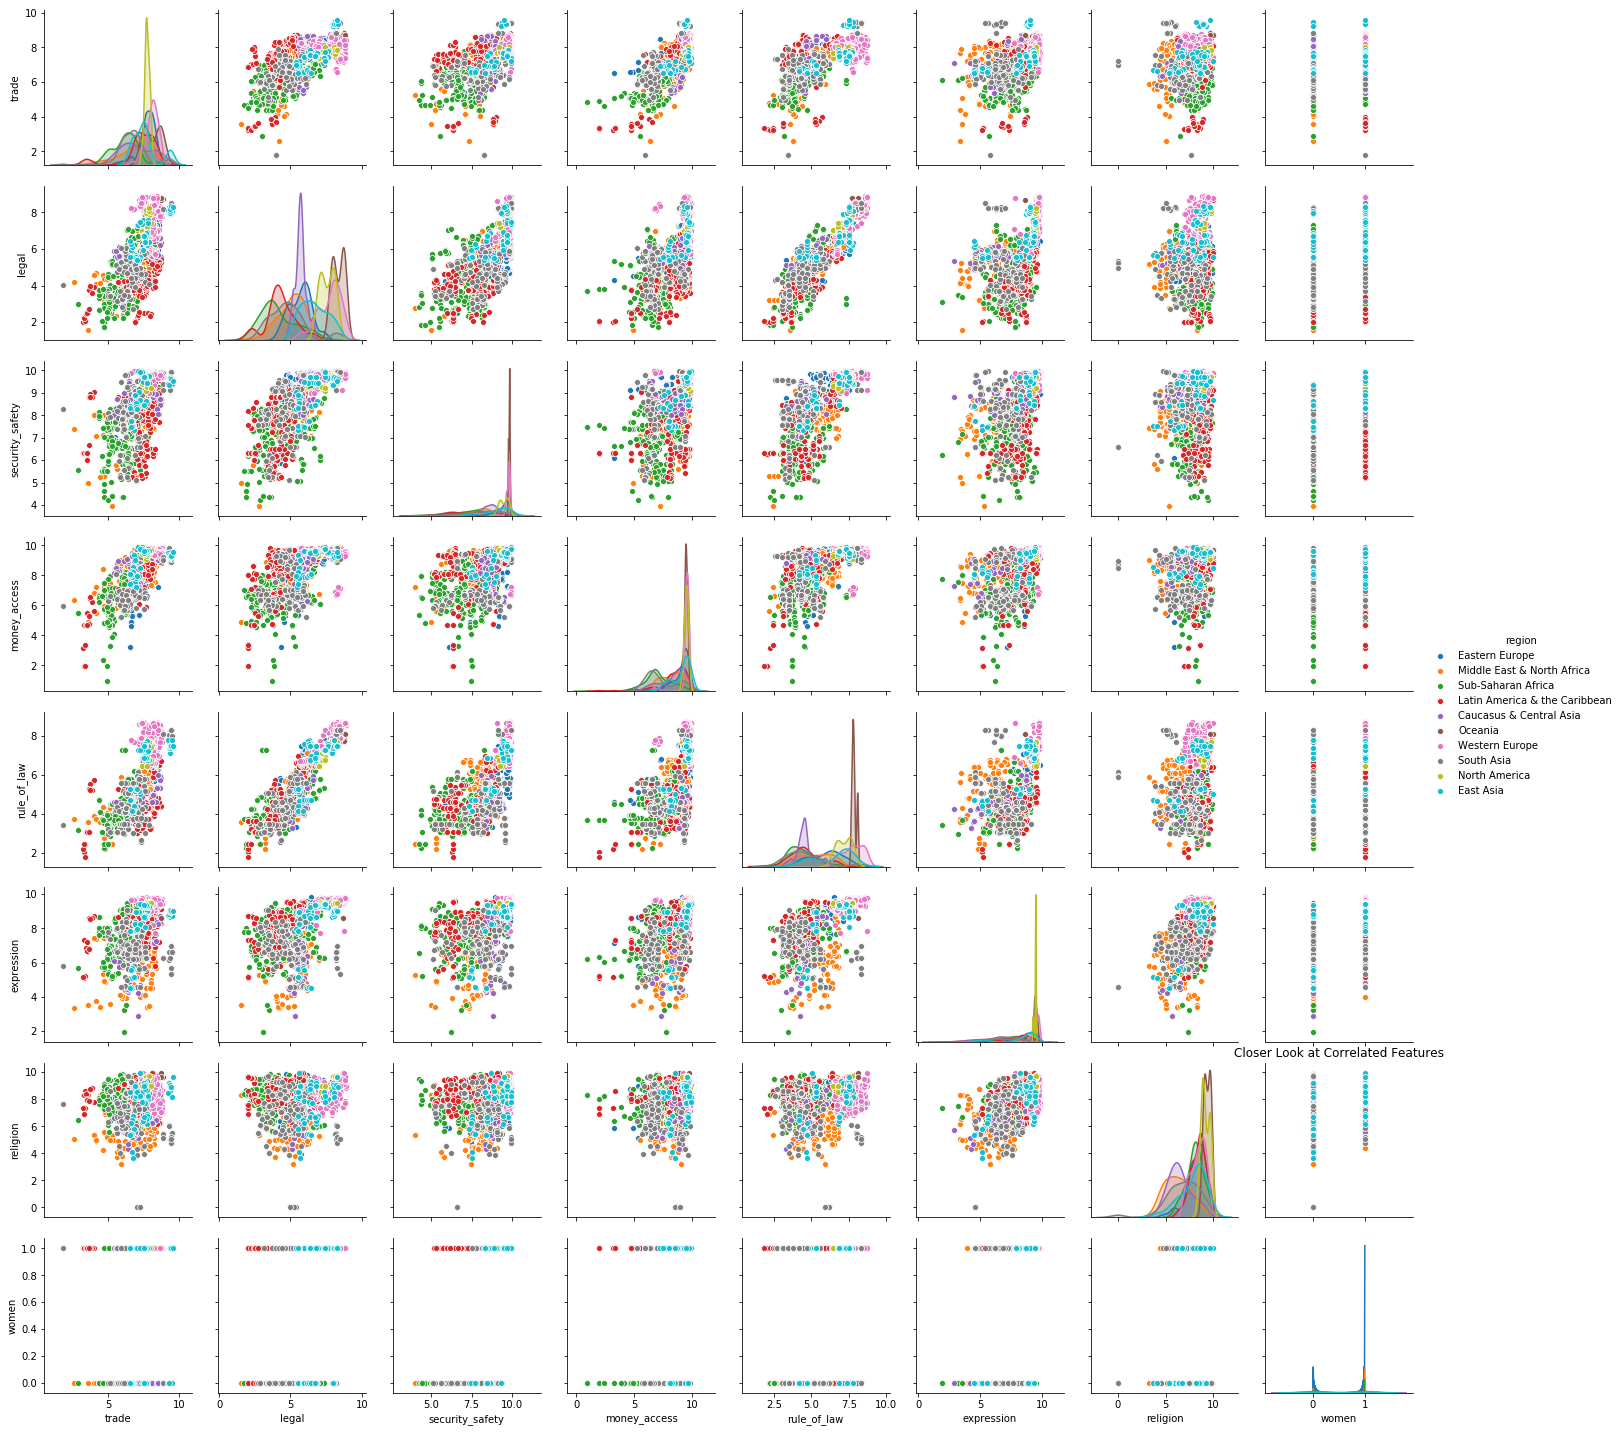

In [79]:
wmn_df = hfi_df[['trade', 'legal', 'security_safety', 'money_access', 
                 'rule_of_law', 'expression', 'religion', 'region', 'women']]
pp = sns.pairplot(data=wmn_df, hue='region')
plt.title('Closer Look at Correlated Features')

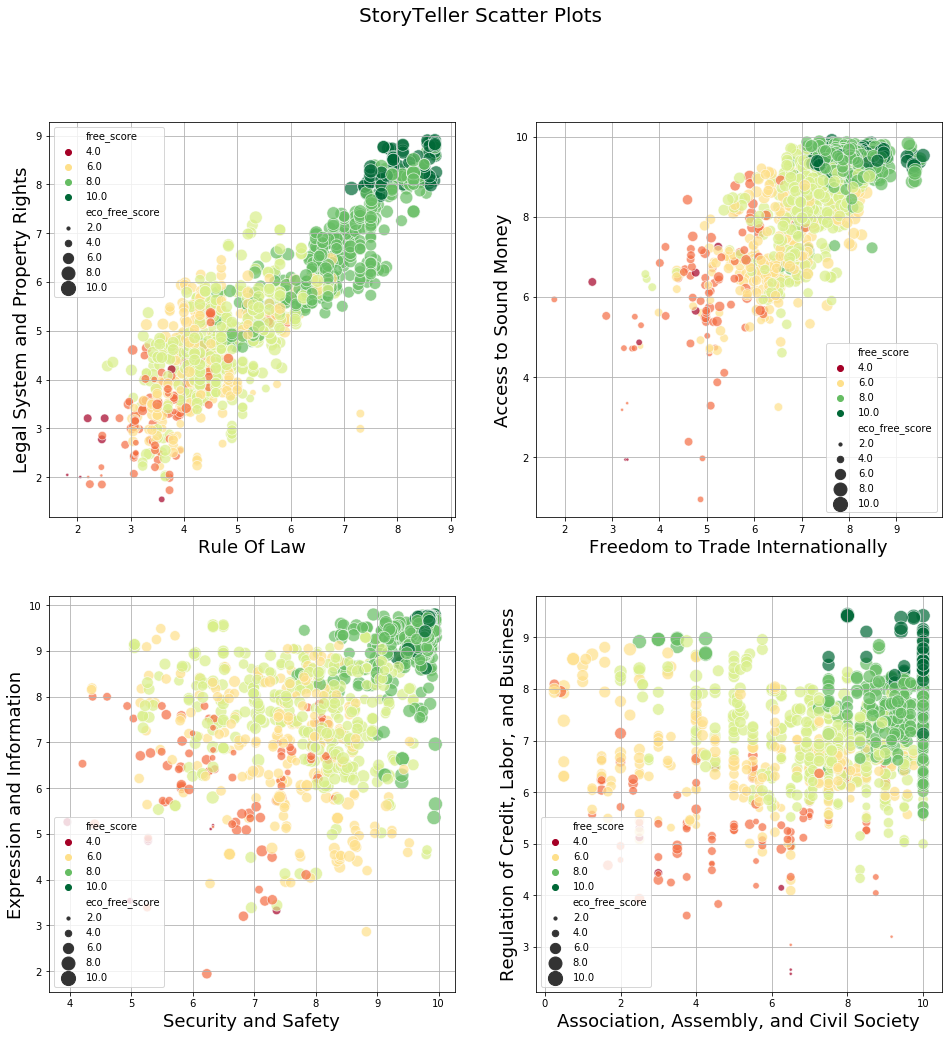

In [24]:
freedom_class = hfi_df.free_score.round(decimals=0)
economy_class = hfi_df.eco_free_score.round(decimals=0)

plt.figure(figsize=(16,16))

plt.suptitle("StoryTeller Scatter Plots",fontsize=20)

plt.subplot(221)
sns.scatterplot(data=hfi_df,x="rule_of_law",y="legal",hue=freedom_class, palette="RdYlGn",alpha=0.7,size=economy_class, sizes=(10,200))
plt.xlabel("Rule Of Law", fontsize=18)
plt.ylabel("Legal System and Property Rights", fontsize=18)
plt.grid()

plt.subplot(222)
sns.scatterplot(data=hfi_df,x="trade",y="money_access",hue=freedom_class, palette="RdYlGn",alpha=0.7,size=economy_class, sizes=(10,200))
plt.xlabel("Freedom to Trade Internationally", fontsize=18)
plt.ylabel("Access to Sound Money", fontsize=18)
plt.grid()

plt.subplot(223)
sns.scatterplot(data=hfi_df,x="security_safety",y="expression",hue=freedom_class, palette="RdYlGn",alpha=0.7,size=economy_class, sizes=(10,200))
plt.xlabel("Security and Safety", fontsize=18)
plt.ylabel("Expression and Information", fontsize=18)
plt.grid()

plt.subplot(224)
sns.scatterplot(data=hfi_df,x="association",y="regulation",hue=freedom_class, palette="RdYlGn",alpha=0.7,size=economy_class, sizes=(10,200))
plt.xlabel("Association, Assembly, and Civil Society", fontsize=18)
plt.ylabel("Regulation of Credit, Labor, and Business", fontsize=18)
plt.grid()

plt.show()

***Size of the each scatter is equals to size Economical Freedom Score. <br>
Color of the each scatter is defined by their Human Freedom Score. ***<br>

***In terms of people's freedom and their economical freedom, there seems to be positive correlation between country's legal systems and rule of law as well as international relations and people's access to money/jobs.***

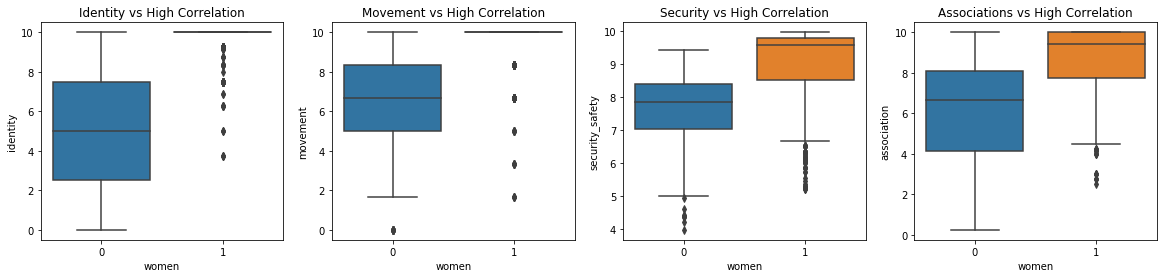

In [25]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# High Correlations with our Class (Women)
sns.boxplot(x="women", y="identity", data=hfi_df, ax=axes[0])
axes[0].set_title('Identity vs High Correlation')

sns.boxplot(x="women", y="movement", data=hfi_df, ax=axes[1])
axes[1].set_title('Movement vs High Correlation')


sns.boxplot(x="women", y="security_safety", data=hfi_df, ax=axes[2])
axes[2].set_title('Security vs High Correlation')


sns.boxplot(x="women", y="association", data=hfi_df, ax=axes[3])
axes[3].set_title('Associations vs High Correlation')

plt.show()

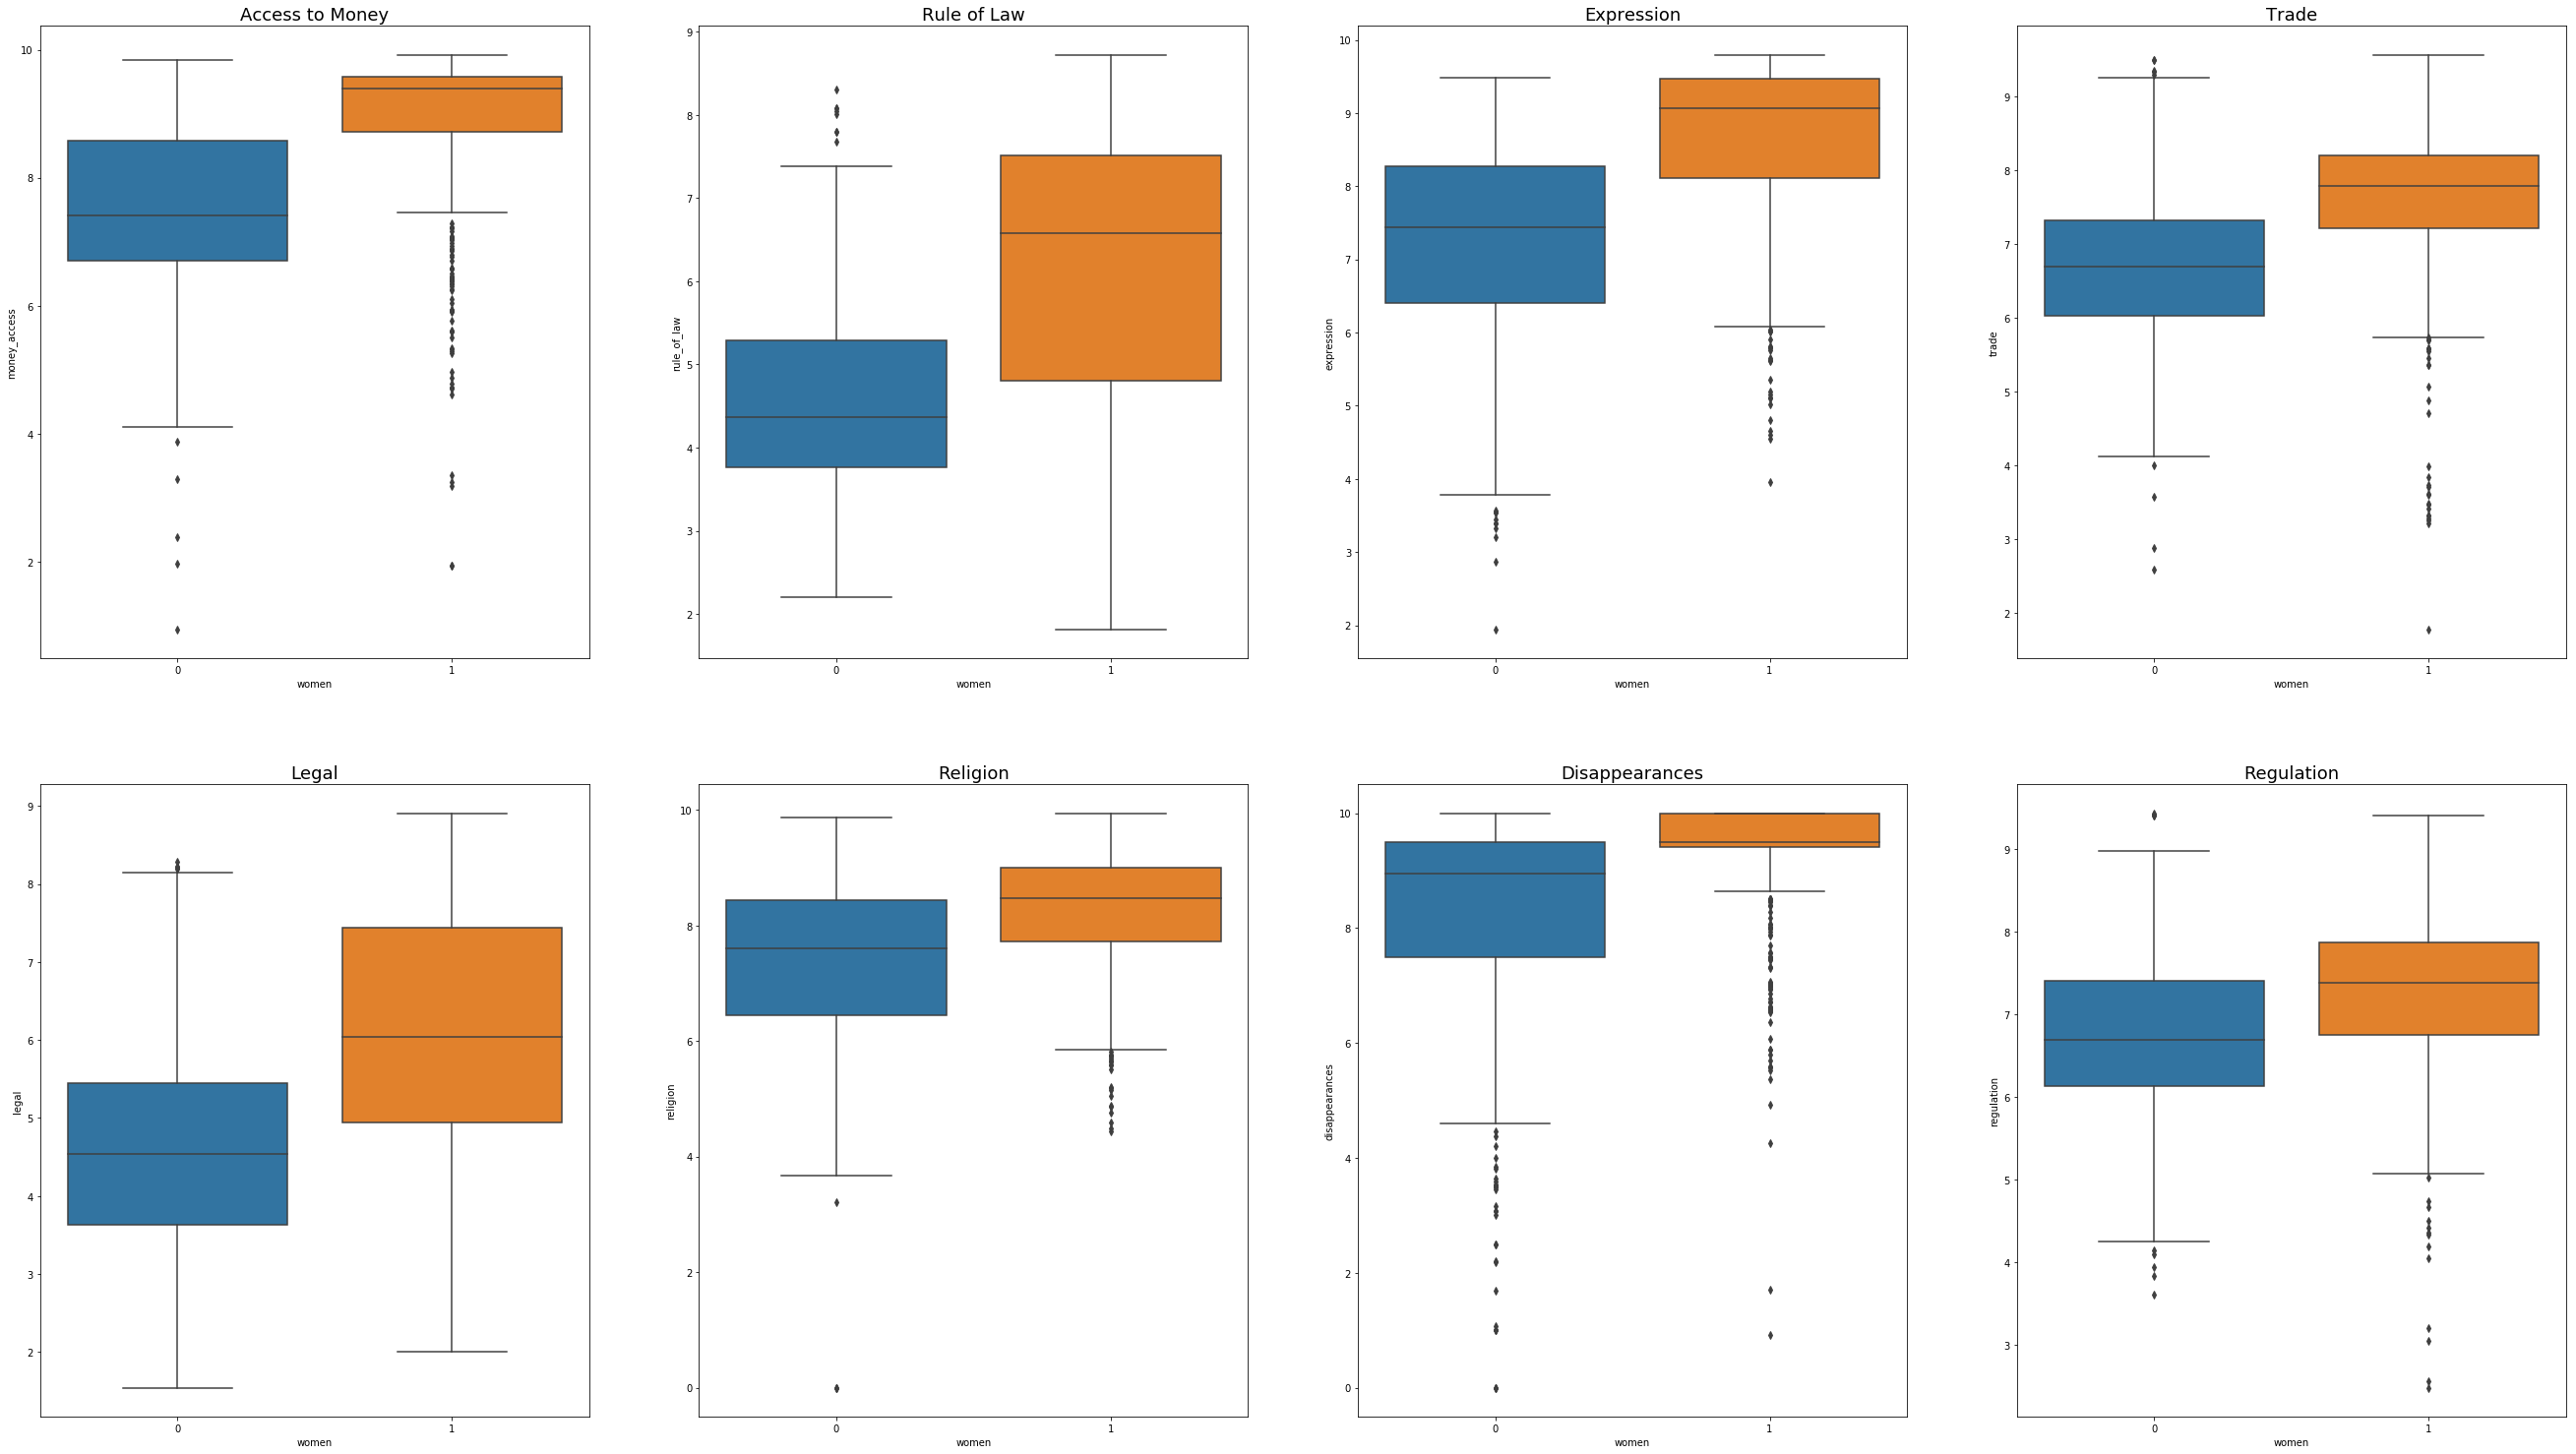

In [26]:
f, axes = plt.subplots(nrows=2, ncols=4, figsize=(46,26))

# High Correlations with our Class (Women)
sns.boxplot(x="women", y="money_access", data=hfi_df, ax=axes[0,0])
axes[0,0].set_title('Access to Money', fontsize= 18)

sns.boxplot(x="women", y="rule_of_law", data=hfi_df, ax=axes[0,1])
axes[0,1].set_title('Rule of Law', fontsize=18)

sns.boxplot(x="women", y="expression", data=hfi_df, ax=axes[0,2])
axes[0,2].set_title('Expression', fontsize=18)

sns.boxplot(x="women", y="trade", data=hfi_df, ax=axes[0,3])
axes[0,3].set_title('Trade', fontsize=18)

sns.boxplot(x="women", y="legal", data=hfi_df, ax=axes[1,0])
axes[1,0].set_title('Legal', fontsize=18)

sns.boxplot(x="women", y="religion", data=hfi_df, ax=axes[1,1])
axes[1,1].set_title('Religion', fontsize=18)


sns.boxplot(x="women", y="disappearances", data=hfi_df, ax=axes[1,2])
axes[1,2].set_title('Disappearances', fontsize=18)


sns.boxplot(x="women", y="regulation", data=hfi_df, ax=axes[1,3])
axes[1,3].set_title('Regulation', fontsize=18)

plt.tight_layout
plt.show()

In [27]:
# To help reduce noise in the training data, we'll get rid of these known outliers in
# features that are highly correlated to our target (Fraudulence)

# winsorize to remove extreme outliers from highly correlated features
import scipy.stats

hfi_df['identity_wins'] = scipy.stats.mstats.winsorize(hfi_df['identity'], limits= [0.05, 0.05])
hfi_df['movement_wins'] = scipy.stats.mstats.winsorize(hfi_df['movement'], limits= [0.05, 0.05])
hfi_df['security_safety_wins'] = scipy.stats.mstats.winsorize(hfi_df['security_safety'], limits= [0.05, 0.05])
hfi_df['association_wins'] = scipy.stats.mstats.winsorize(hfi_df['association'], limits= [0.05, 0.05])

hfi_df['money_access_wins'] = scipy.stats.mstats.winsorize(hfi_df['money_access'], limits= [0.05, 0.05])
hfi_df['expression_wins'] = scipy.stats.mstats.winsorize(hfi_df['expression'], limits= [0.05, 0.05])
hfi_df['trade_wins'] = scipy.stats.mstats.winsorize(hfi_df['trade'], limits= [0.05, 0.05])
hfi_df['religion_wins'] = scipy.stats.mstats.winsorize(hfi_df['religion'], limits= [0.05, 0.05])
hfi_df['disappearances_wins'] = scipy.stats.mstats.winsorize(hfi_df['disappearances'], limits= [0.05, 0.05])
hfi_df['regulation_wins'] = scipy.stats.mstats.winsorize(hfi_df['regulation'], limits= [0.05, 0.05])

In [28]:
hfi_df.drop(columns=['identity', 'movement', 'security_safety', 'association', 'money_access', 
                     'expression','trade', 'religion', 'disappearances', 'regulation'])

,year,country,region,rule_of_law,homicide,government,legal,pers_free_score,pers_free_rank,eco_free_score,...,identity_wins,movement_wins,security_safety_wins,association_wins,money_access_wins,expression_wins,trade_wins,religion_wins,disappearances_wins,regulation_wins
0,2016,Albania,Eastern Europe,5.291752,8.920429,7.935564,5.071814,7.596281,57.0,7.54,...,6.250000,6.666667,8.806810,10.000000,9.553657,8.607143,8.214900,9.192593,10.000000,6.906901
1,2016,Algeria,Middle East & North Africa,3.819566,9.456254,3.616782,4.690743,5.281772,147.0,4.99,...,0.833333,5.000000,8.043882,5.000000,7.253894,7.380952,4.987084,5.153333,8.842060,5.268992
2,2016,Angola,Sub-Saharan Africa,3.451814,8.060260,6.496685,2.963635,6.111324,117.0,5.17,...,7.500000,5.000000,8.297865,4.000000,5.689791,6.452381,5.264754,8.786667,8.500000,5.518500
3,2016,Argentina,Latin America & the Caribbean,5.744791,7.622974,5.346056,3.904030,8.099696,42.0,4.84,...,10.000000,10.000000,9.040383,7.500000,5.689791,8.738095,4.987084,7.795926,9.498175,5.369019
4,2016,Armenia,Caucasus & Central Asia,5.003205,8.808750,7.003310,5.809215,6.912804,84.0,7.57,...,8.000000,6.666667,8.830549,6.500000,9.521940,7.154762,8.143241,6.222222,9.349563,7.378069
5,2016,Australia,Oceania,7.776279,9.623538,6.544178,7.919019,9.184438,11.0,7.98,...,9.250000,10.000000,9.871829,10.000000,9.452540,9.392857,7.526721,9.075926,9.998348,8.465526
6,2016,Austria,Western Europe,8.171749,9.737912,5.086295,7.915987,9.246948,8.0,7.58,...,10.000000,10.000000,9.871829,10.000000,9.432830,9.333333,8.106733,7.925185,10.000000,7.371334
7,2016,Azerbaijan,Caucasus & Central Asia,4.270861,9.143499,5.175449,5.652732,5.676553,131.0,6.49,...,6.250000,5.000000,8.667524,3.000000,7.513487,5.089607,7.216525,5.461111,8.525738,6.874880
9,2016,Bahrain,Middle East & North Africa,5.900339,9.790481,8.317485,5.265602,6.136070,114.0,7.56,...,3.333333,6.666667,8.006968,5.000000,9.404353,5.089607,7.403403,7.461481,8.397088,7.415786
10,2016,Bangladesh,South Asia,3.132892,8.998765,8.545118,3.234259,5.302600,146.0,6.30,...,1.250000,5.000000,7.587380,7.000000,6.983617,7.041990,6.039373,5.933333,7.930041,6.690103


***I'm going to run vanilla models of Logistic Regression, SVM and KNN through grid search . Then I'll run XGBoost.***

In [53]:
hfi_df.shape

(1127, 34)

In [54]:
# Features and Target data
X = hfi_df.drop(['women', 'year', 'country', 'region', 'security_safety', 
                 'pers_free_rank', 'eco_free_rank', 'free_rank'], axis=1)
y = hfi_df['women']

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
# I'll be using GridSearchCV to find the best classfier so I'll turn 
# the values into an array to feed into the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [56]:
# Implementing vanilla classifiers
#LogisiticRegression == LogR
#KNearest == KNN
#Support Vector Classifier == SVC
#DecisionTreeClassifier == DTC
classifiers = {
    "LogR": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "SVC": SVC()
}

Classifiers:  LogisticRegression Has a 96.0 % training accuracy score
Classifiers:  KNeighborsClassifier Has a 91.0 % training accuracy score
Classifiers:  SVC Has a 94.0 % training accuracy score


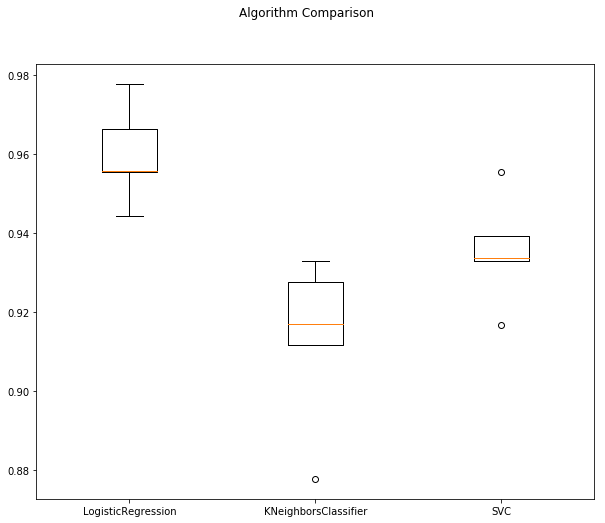

In [57]:
results = []
names = []

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    results.append(training_score)
    names.append(classifier.__class__.__name__)
    print("Classifiers: ", classifier.__class__.__name__, "Has a", 
          round(training_score.mean(), 2) * 100, "% training accuracy score")
    
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Logistic Regression has clearly outperformed the other two classifiers, but there's quite a bit of variance.

In [58]:
# Use Grid Search to find the best parameters for each model

# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# GS logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": [2,3,4,5,7], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best parameters
knn = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear'], 
              'gamma':[0.001, 0.01, 0.1, 1, 10]}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best parameters
svc = grid_svc.best_estimator_


print(log_reg, '\n LR best Score ', grid_log_reg.best_score_)
print(knn, '\n KNN best Score ', grid_knears.best_score_)
print(svc, '\n SVC best Score ', grid_svc.best_score_)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False) 
 LR best Score  0.9944506104328524
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform') 
 KNN best Score  0.9267480577136515
SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 
 SVC best Score  0.9922308546059934


**No longer running vanilla! By selecting better parameters for each model, I've improved the results of all three with logistic regression still performing the best, but SVC is a very close second. I'm going to look at the precision and accuracy now.**

In [59]:
from sklearn.metrics import confusion_matrix

lr_pred = grid_log_reg.predict(X_test)
# Compute confusion matrix
labels = [0,1]
lr_cnf_matrix = confusion_matrix(y_test,lr_pred,labels)
np.set_printoptions(precision=2)

print(lr_cnf_matrix)

[[113   0]
 [  0 113]]


In [60]:
knn_pred = grid_knears.predict(X_test)
# Compute confusion matrix
labels = [0,1]
knn_cnf_matrix = confusion_matrix(y_test,knn_pred,labels)
np.set_printoptions(precision=2)

print(knn_cnf_matrix)

[[112   1]
 [  6 107]]


In [61]:
svc_pred = grid_svc.predict(X_test)
# Compute confusion matrix
labels = [0,1]
svc_cnf_matrix = confusion_matrix(y_test,svc_pred,labels)
np.set_printoptions(precision=2)

print(svc_cnf_matrix)

[[111   2]
 [  1 112]]


__Terms:__ <br>
__True Positives:__ Correctly Classified Safe/Free Women <br>
__False Positives:__ Incorrectly Classified Safe/Free Women <br>
__True Negative:__ Correctly Classified Unsafe/non-Free Women <br>
__False Negative:__ Incorrectly Classified Unsafe/non-Free Women <br>
__Precision:__ True Positives/(True Positives + False Positives) <br>
__Recall:__ True Positives/(True Positives + False Negatives) <br>
___Precision___ as the name says, says how precise (how sure) is our model in detecting Safe/Free Women while ___recall___ is the amount of Safe/Free Women cases our model is able to detect. <br>
__Precision/Recall Tradeoff:__ The more precise (selective) our model is, the less actual positive cases it will detect. 

In [62]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, classification_report

y_pred = log_reg.predict(X_train)

print('Overfitting: \n')
print('Recall Score: {:.3f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.3f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.3f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.3f}'.format(accuracy_score(y_train, y_pred)))

Overfitting: 

Recall Score: 1.000
Precision Score: 1.000
F1 Score: 1.000
Accuracy Score: 1.000


In [63]:
# Visualize the results

from sklearn.model_selection import cross_val_predict

# Create a DataFrame with all the scores and the classifiers names.
log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knn_pred = cross_val_predict(knn, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")

In [64]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knn_fpr, knn_tpr, knn_threshold = roc_curve(y_train, knn_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)

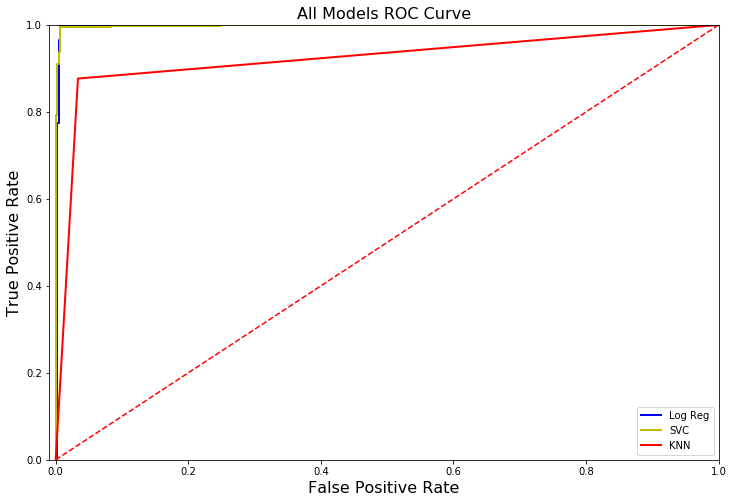

In [65]:
# A visualization of each ROC curve

#plotting a single ROC curve
def model_roc_curve(model_fpr, model_tpr, title,label):
    plt.figure(figsize=(12,8))
    plt.title(title, fontsize=16)
    plt.plot(model_fpr, model_tpr, 'b-', linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])
    

# All curves
all_title = 'All Models ROC Curve'
log_label = 'Log Reg'
model_roc_curve(log_fpr, log_tpr, all_title, log_label)
plt.plot(svc_fpr, svc_tpr, 'y-', linewidth=2, label='SVC')
plt.plot(knn_fpr, knn_tpr, 'r-', linewidth=2, label='KNN')
plt.legend()
plt.show()

**KNN works by grouping/clustering classes together. Being that KNN barely improved, my data sleaning was effective to the point it removed the noise. With the onise greatly reduced, SVC was able to sort things with ease.** <br>
**I was able to use common sense about the data to remove outliers, and missing data without compromising the integrity of the dataset.** <br>
**The initial dataset was 1458 rows deep and 123 columsn across. I was able to get rid of redundent  features and remove missing data bringing the shape to 1127 rows and 34 columns (24 + 10 winsorized columns).** <br>
**I removed the original columns that were winsorized, the categorical features, and the ranked features (as to not be redundant with their scores).**


## XGBoost

In [66]:
# Boosted Trees (XGBoost)
import xgboost as xgb
from sklearn.metrics import mean_squared_error

X, y = hfi_df.drop(['women', 'year', 'country', 'region', 'security_safety', 
                    'pers_free_rank', 'eco_free_rank', 'free_rank'], axis=1),hfi_df.women

data_dmatrix = xgb.DMatrix(data=X,label=y)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

In [68]:
# alpha = L1 = Lasso, 5 trees deep, 10 trees build
xg_reg = xgb.XGBRegressor(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [69]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

In [70]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.303247


In [71]:
roc_auc_score(y_test, preds)

0.9790633608815428

In [72]:
params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="auc", as_pandas=True, seed=33)

[12:19:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[12:19:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[12:19:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[12:19:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[12:19:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:19:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[12:19:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:19:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[12:19:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_

[12:19:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[12:19:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[12:19:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:19:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:19:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[12:19:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[12:19:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[12:19:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[12:19:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_

In [73]:
cv_results.head()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.928959,0.001037,0.903456,0.016960
1,0.964041,0.007092,0.948337,0.012836
2,0.965065,0.006776,0.951684,0.012999
3,0.968344,0.005563,0.953859,0.014756
4,0.968251,0.004679,0.954776,0.014842


In [74]:
# final AUC score
print((cv_results["test-auc-mean"]).tail(1))

49    0.972784
Name: test-auc-mean, dtype: float64


In [75]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[12:19:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[12:19:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[12:19:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[12:19:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[12:19:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:19:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:19:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[12:19:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:19:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_

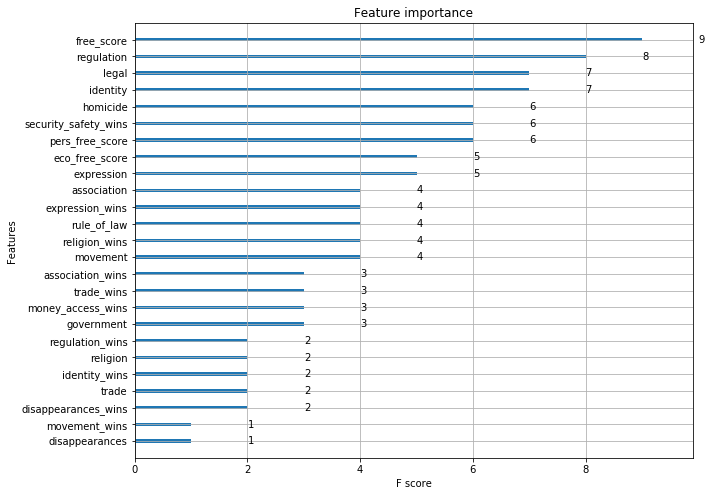

<Figure size 720x540 with 0 Axes>

In [76]:
xgb.plot_importance(xg_reg)
plt.figure(figsize = (10, 7.5))
plt.rcParams['figure.figsize'] = [10, 8]
plt.show()